In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

import os

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [4]:
df.iloc[6]['comment_text']

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

In [5]:
df[df.columns[2:]].iloc[6]

toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 6, dtype: int64

PREPROCESSING
1. Tokenisation :- converting each word to an identifier so that each word maps towards a number for the sake of NN to understand it

In [6]:
## TOKENISATION
from tensorflow.keras.layers import TextVectorization

In [7]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [8]:
X.shape, y.shape

((159571,), (159571, 6))

In [9]:
# number of words in the vocabulary
MAX_FEATURES = 200000

In [10]:
from pandas.core.arrays import integer
# applying tokensisation
vectoriser = TextVectorization(max_tokens=MAX_FEATURES, output_sequence_length=2000,output_mode='int')

In [11]:
%%time
vectoriser.adapt(X.values)

CPU times: user 21.2 s, sys: 1.1 s, total: 22.3 s
Wall time: 13.9 s


In [ ]:
vectoriser.get_vocabulary()

In [13]:
vectorised_text = vectoriser(X.values)

In [14]:
vectorised_text

<tf.Tensor: shape=(159571, 2000), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [15]:
# CREATING THE DATASET 
dataset = tf.data.Dataset.from_tensor_slices((vectorised_text,y))

In [16]:
## DATASET SEQUENCING THROUTH PIPELINE
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) 

In [17]:
dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 2000), dtype=tf.int64, name=None), TensorSpec(shape=(None, 6), dtype=tf.int64, name=None))>

In [18]:
# taking a peek at the fresh dataset as per batches
# with text in the vectorized format, plus all the labels
dataset.as_numpy_iterator().next()

(array([[2792,    8,  324, ...,    0,    0,    0],
        [ 208, 4324,   41, ...,    0,    0,    0],
        [ 797,   27,   91, ...,    0,    0,    0],
        ...,
        [1321,    3,  298, ...,    0,    0,    0],
        [  94,   13,    7, ...,    0,    0,    0],
        [  76,  201,   97, ...,    0,    0,    0]]), array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [19]:
batch_x, batch_y = dataset.as_numpy_iterator().next()

In [20]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [21]:
# length of dataset in batches of 16
len(dataset)

9974

CREATING TRAIN, TEST AND VALIDATION DATA

In [22]:
# alloting 70% to training data, 20% to validation and rest to Testing
train = dataset.take(int(len(dataset)*0.7))

# first skipping the first 70% data and fetching the next 20%
validation = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))

# skipping the first 90% data and fetching the rest 10%
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [23]:
len(train), len(test), len(validation) # in batches of 16

(6981, 997, 1994)

In [24]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 2000), dtype=tf.int64, name=None), TensorSpec(shape=(None, 6), dtype=tf.int64, name=None))>

In [25]:
train.as_numpy_iterator().next()

(array([[   166,     77,   1067, ...,      0,      0,      0],
        [    40,    745,      3, ...,      0,      0,      0],
        [     5,    123,      2, ...,      0,      0,      0],
        ...,
        [113882,   1317,     23, ...,      0,      0,      0],
        [   125,   7122,   1251, ...,      0,      0,      0],
        [    21,      1,   7783, ...,      0,      0,      0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0]]))

BUILDING THE DEEP NEURAL NETWORK

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, Bidirectional, LSTM, Embedding

In [27]:
model = Sequential()

If we use one-hot encoding on words in textual data, we will have a dummy feature for each word, which means 10,000 features for a vocabulary of 10,000 words. This is not a feasible embedding approach as it demands large storage space for the word vectors and reduces model efficiency.

Embedding layer enables us to convert each word into a fixed length vector of defined size

In [28]:
# Creating the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32)) 

# the GPU acceleration required for the LSTM needs 'tanh'. Although 'relu' can be used as well
# Bidirectional allows you to pass informa ion in both direction; particularly on sentences
model.add(Bidirectional(LSTM(32, activation = 'tanh')))


model.add(Dense(128, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))

# output vlayer
model.add(Dense(6, activation = 'sigmoid')) # sigmoid gives us a 0 or 1 output.






In [36]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [38]:
%%time
classifier = model.fit(train, epochs = 10,validation_data = validation)

Epoch 1/10
6981/6981 [==============================] - 676s 96ms/step - loss: 0.0627 - accuracy: 0.9828 - val_loss: 0.0439 - val_accuracy: 0.9940
Epoch 2/10
6981/6981 [==============================] - 681s 98ms/step - loss: 0.0460 - accuracy: 0.9935 - val_loss: 0.0419 - val_accuracy: 0.9937
Epoch 3/10
6981/6981 [==============================] - 680s 97ms/step - loss: 0.0409 - accuracy: 0.9931 - val_loss: 0.0364 - val_accuracy: 0.9942
Epoch 4/10
6981/6981 [==============================] - 680s 97ms/step - loss: 0.0370 - accuracy: 0.9855 - val_loss: 0.0308 - val_accuracy: 0.9949
Epoch 5/10
6981/6981 [==============================] - 687s 98ms/step - loss: 0.0327 - accuracy: 0.9932 - val_loss: 0.0295 - val_accuracy: 0.9911
Epoch 6/10
6981/6981 [==============================] - 681s 98ms/step - loss: 0.0293 - accuracy: 0.9915 - val_loss: 0.0260 - val_accuracy: 0.9943
Epoch 7/10
6981/6981 [==============================] - 682s 98ms/step - loss: 0.0259 - accuracy: 0.9906 - val_loss: 0

In [39]:
classifier.history

{'accuracy': [0.9827925562858582,
  0.9934644103050232,
  0.9930615425109863,
  0.9854963421821594,
  0.993186891078949,
  0.9915216565132141,
  0.990626335144043,
  0.9749588370323181,
  0.9915753602981567,
  0.9882001280784607],
 'loss': [0.06267236173152924,
  0.04604221507906914,
  0.040858831256628036,
  0.03695195913314819,
  0.03272239491343498,
  0.02933536469936371,
  0.02585615962743759,
  0.023770475760102272,
  0.020837200805544853,
  0.019093336537480354],
 'val_accuracy': [0.9940133094787598,
  0.993699848651886,
  0.9942013621330261,
  0.9948595762252808,
  0.9911296367645264,
  0.9942953586578369,
  0.9943894147872925,
  0.9920699596405029,
  0.9944521188735962,
  0.9925714731216431],
 'val_loss': [0.043946266174316406,
  0.0419125072658062,
  0.0364437997341156,
  0.030812548473477364,
  0.029487665742635727,
  0.026010029017925262,
  0.02223167195916176,
  0.019782699644565582,
  0.0183291994035244,
  0.015903102234005928]}

visualisations

In [41]:
import matplotlib.pyplot as plt

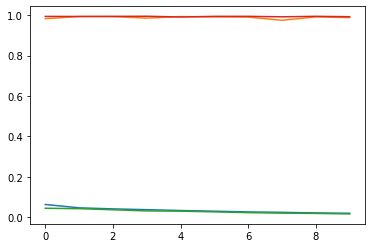

In [42]:
plt.plot(pd.DataFrame(classifier.history))
plt.show()

MAKING PREDICTIONS

In [44]:
input = vectoriser("You son of a bitch!")

In [45]:
# test data
test.as_numpy_iterator().next()

(array([[   46,   168,   462, ...,     0,     0,     0],
        [ 1051,   635,   179, ...,     0,     0,     0],
        [ 1262,  1062,   880, ...,     0,     0,     0],
        ...,
        [ 2994,    23,    53, ...,     0,     0,     0],
        [  451, 73437, 78345, ...,     0,     0,     0],
        [ 1619,   430,    11, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

In [49]:
batch_x,batch_y = test.as_numpy_iterator().next()

In [63]:
# prediction
prediction = model.predict(batch_x).astype(int) #input should be a numpy array

In [64]:
# taking a look at the predictions
prediction

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

MODEL EVALUATION

In [53]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [55]:
from pandas.core.arrays.categorical import CategoricalAccessor
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()

In [57]:
%%time

for batch in test.as_numpy_iterator():
  X_test, y_test = batch
  y_predict = model.predict(X_test)


# Flattening the predictions
  y_test = y_test.flatten()
  y_predict = y_predict.flatten()


  # updating the metrics
  precision.update_state(y_test,y_predict)
  recall.update_state(y_test,y_predict)
  accuracy.update_state(y_test,y_predict)

CPU times: user 1min 28s, sys: 2.33 s, total: 1min 30s
Wall time: 1min 29s


In [58]:
print(f'Precision: {precision.result().numpy()}, Recall:{recall.result().numpy()}, Accuracy:{accuracy.result().numpy()}')

Precision: 0.9315667152404785, Recall:0.9080329537391663, Accuracy:0.5185556411743164


GRADIO APPLICATION IMPLEMENTATION ( extra )

In [59]:
!pip install gradio jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.1 MB 4.8 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 2.0 MB 12.3 MB/s 
     |████████████████████████████████| 1.1 MB 49.5 MB/s 
     |████████████████████████████████| 53 kB 2.6 MB/s 
     |████████████████████████████████| 253 kB 73.6 MB/s 
     |████████████████████████████████| 212 kB 59.0 MB/s 
     |████████████████████████████████| 144 kB 58.4 MB/s 
     |████████████████████████████████| 271 kB 75.8 MB/s 
     |████████████████████████████████| 94 kB 4.6 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
     |████████████████████████████████| 11.1 MB 52.3 MB/s 
     |████████████████████████████████| 80 kB 10.0 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 4.0 

In [60]:
import gradio as gradio

In [66]:
model.save('toxicity.h5')

In [67]:
def score_comment(comment):
    vectorized_comment = vectoriser([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [70]:
interface = gradio.Interface(fn=score_comment, 
                         inputs=gradio.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


In [71]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://56568.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x7fb6d052e610>,
 'http://127.0.0.1:7860/',
 'https://56568.gradio.app')